In [12]:
# imports

import pandas as pd
import numpy as np
import os
import math
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [13]:
# helper functions

def split(X, y, ratio):    
    test_split = int(len(X) * ratio)
    
    X_train, y_train = X[:test_split], y[:test_split]
    X_test, y_test = X[test_split:], y[test_split:]
    return X_train, y_train, X_test, y_test

def plot_results(predicted_data, true_data):
    matplotlib.rcParams.update({'font.size': 14})
    fig = plt.figure(facecolor='white', figsize=(12,7)) 
    ax = fig.add_subplot(111)
    ax.plot(true_data, '-', label='True Data')
    plt.plot(predicted_data, 'o', label='Prediction')
    plt.xlabel('Time (s)', fontsize=18)
    plt.ylabel('Activation', fontsize=18)
    plt.legend(fontsize=18)
    plt.show()
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(12,7)) 
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [4]:
# globals

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
EXTERNALS_PATH = 'data/externals'

In [ ]:
# train-test split

X = np.load(os.path.join(PROJ_ROOT, EXTERNALS_PATH, 'X.npy'))
y = np.load(os.path.join(PROJ_ROOT, EXTERNALS_PATH, 'y.npy'))
X_train, y_train, X_test, y_test = split(X, y, ratio=0.8)

## Model: 3 layers; 1 training epoch

In [5]:
from keras.models import load_model
model = load_model('../saved_models/01052019-092342-e1.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [6]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print(f'Train Score: {trainScore} MSE ({math.sqrt(trainScore)} RMSE)')

testScore = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Score: {testScore} MSE ({math.sqrt(testScore)} RMSE)')

Train Score: 0.006708766659756012 MSE (0.08190706111048066 RMSE)
Train Score: 3.605395133169648e-06 MSE (0.0018987878062515695 RMSE)


In [7]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [8]:
# how many activations in actual testing set
unique, counts = np.unique(y_test, return_counts=True)
np.asarray((unique, counts)).T

array([[0.000000e+00, 5.824563e+06],
       [1.000000e+00, 2.100000e+01]])

In [9]:
# how many unique model's output values 
y_test_pred = np.reshape(y_test_pred, (y_test_pred.size,))
unique, counts = np.unique(y_test_pred, return_counts=True)
np.asarray((unique, counts)).T

array([[2.83986310e-06, 5.82448400e+06],
       [5.11099825e-06, 2.00000000e+01],
       [5.55253246e-06, 2.00000000e+01],
       [6.64734034e-06, 2.00000000e+01],
       [8.57259147e-06, 2.00000000e+01],
       [9.02726970e-06, 2.00000000e+01]])

In [10]:
# interpreting LSTM output values

y_test_pred[y_test_pred==2.83986310e-06]=0
y_test_pred[y_test_pred!=0]=1
y_test_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

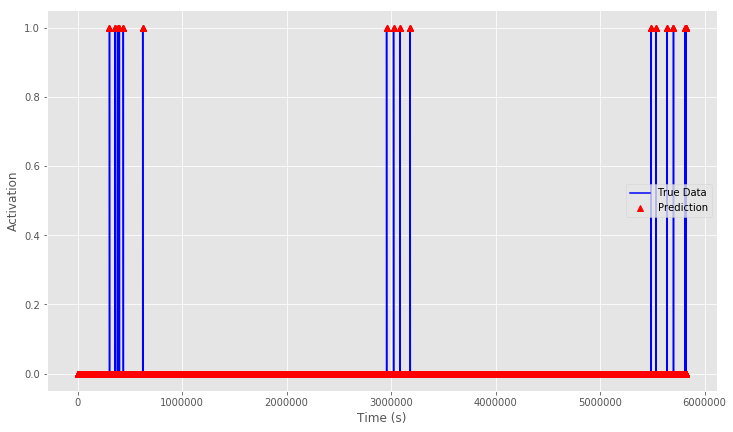

In [11]:
plot_results(predicted_data=y_test_pred, 
             true_data=y_test)

## Model: 5 layers; 10 training epochs

In [21]:
from keras.models import load_model
model = load_model('../saved_models/29052019-164232-e10.h5')

In [22]:
y_train_pred_10 = model.predict(X_train)
y_test_pred_10 = model.predict(X_test)

In [23]:
# how many unique model's output values 
y_test_pred_10 = np.reshape(y_test_pred_10, (y_test_pred_10.size,))
unique, counts = np.unique(y_test_pred_10, return_counts=True)
np.asarray((unique, counts)).T

array([[1.21673493e-05, 5.82448400e+06],
       [1.52176805e-03, 2.00000000e+01],
       [1.84416212e-03, 2.00000000e+01],
       [1.91396230e-03, 2.00000000e+01],
       [1.91468524e-03, 2.00000000e+01],
       [1.91875699e-03, 2.00000000e+01]])

In [24]:
# interpreting LSTM output values

y_test_pred_10[y_test_pred_10==1.21673493e-05]=0
y_test_pred_10[y_test_pred_10!=0]=1
y_test_pred_10

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [26]:
# save the output for the further evaluation
np.save(os.path.join(PROJ_ROOT, EXTERNALS_PATH, 'y_test_pred_10.npy'), y_test_pred_10)

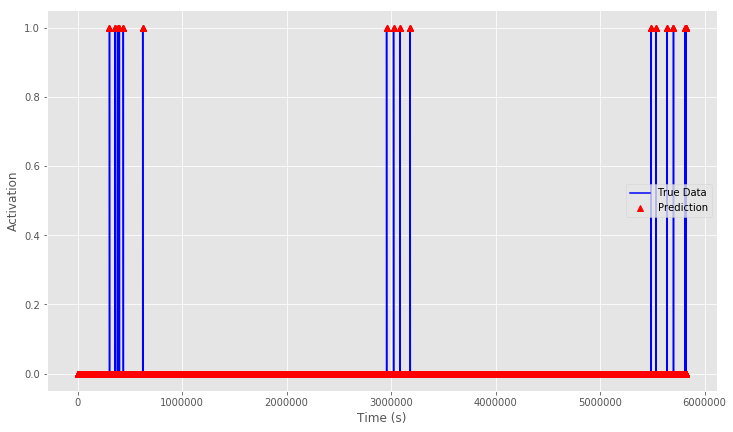

In [27]:
plot_results(predicted_data=y_test_pred_10, 
             true_data=y_test)

# Predicting future sequnces 

## Model: 5 layers; 10 training epochs

In [6]:
from keras.models import load_model
model = load_model('../saved_models/29052019-164232-e10.h5')

In [7]:
def predict_sequences_multiple(data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [9]:
y_test_pred_10_seq = predict_sequences_multiple(data=X_test, 
                                                window_size=5, 
                                                prediction_len=10)

# Figures refurbishment (before letter)

In [5]:
# assessing the 22.10.2019. model output
y_train_pred = np.load(os.path.join(PROJ_ROOT, EXTERNALS_PATH, 'y_train_pred.npy'))
y_test_pred = np.load(os.path.join(PROJ_ROOT, EXTERNALS_PATH, 'y_test_pred.npy'))
y = np.load(os.path.join(PROJ_ROOT, EXTERNALS_PATH, 'y.npy'))
y_test = y[-len(y_test_pred):]

In [6]:
y_test_pred = np.reshape(y_test_pred, (y_test_pred.size,))
unique, counts = np.unique(y_test_pred, return_counts=True)
np.asarray((unique, counts)).T

array([[1.46799903e-05, 5.82448400e+06],
       [1.60810414e-05, 2.00000000e+01],
       [1.83247303e-05, 2.00000000e+01],
       [2.40590543e-05, 2.00000000e+01],
       [3.39290709e-05, 2.00000000e+01],
       [9.44096537e-04, 2.00000000e+01]])

In [7]:
y_test_pred[y_test_pred==1.46799903e-05]=0
y_test_pred[y_test_pred==1.60810414e-05]=0
y_test_pred[y_test_pred==1.83247303e-05]=0
y_test_pred[y_test_pred==2.40590543e-05]=0
y_test_pred[y_test_pred==3.39290709e-05]=0
y_test_pred[y_test_pred!=0]=1

/home/alk/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


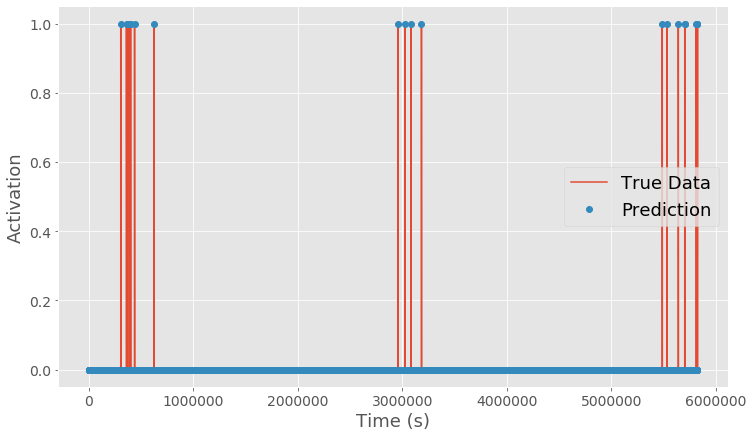

In [14]:
plot_results(predicted_data=y_test_pred, 
             true_data=y_test)

In [18]:
# error assessment
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
print(PROJ_ROOT)

DATASET_PATH = 'data/raw'

data_fname = os.path.join(PROJ_ROOT, DATASET_PATH, 'LORA_data.csv')
dframe = pd.read_csv(data_fname, header=0, sep=';')
dframe.head()

/home/alk/github/lora-time-series


,Time,DevAddr,Freq,Chan,BW,SPF,RSSI,SNR,4/5,dataRate,crcStatus,mType,macPayload,_id
0,2017-01-02 12:08:27.788000,000013c1,868100000,0,125,7,-120,-1.0,4/5,"{u'modulation': u'LORA', u'bandwidth': 125, u'...",1,Confirmed Data Up,c1130000804605039977d43d70b12724eea946c5a41f42...,586a34acb5866106ea976eb5
1,2017-01-02 12:08:29.196000,000013b8,868500000,2,125,7,-58,6.5,4/5,"{u'modulation': u'LORA', u'bandwidth': 125, u'...",1,Confirmed Data Up,b813000000142b0352619fc9a89e0e561d060ca3ac29e5...,586a34aeb5866106ea976eb6
2,2017-01-02 12:08:44.520000,000013bf,868300000,1,125,7,"-118,8",-1.8,4/5,"{u'modulation': u'LORA', u'bandwidth': 125, u'...",1,Confirmed Data Up,bf13000080ba30042ea26888992702442c832fc2c8ac91...,586a34bdb5866106ea976eb7
3,2017-01-02 12:08:55.347000,000013bf,868500000,2,125,7,-115,1.8,4/5,"{u'modulation': u'LORA', u'bandwidth': 125, u'...",1,Confirmed Data Up,bf13000080bb30030a96702f4ebe2cfe8559765a622344...,586a34c8b5866106ea976eb8
4,2017-01-02 12:08:55.346000,000013bf,868500000,2,125,7,-115,1.8,4/5,"{u'modulation': u'LORA', u'bandwidth': 125, u'...",1,Confirmed Data Up,bf13000080bb30030a96702f4ebe2cfe8559765a622344...,586a34c8b5866106ea976eb9


In [21]:
def remove_ns(data):
    Time = list(data.Time.values)
    Time_parsed = []
    sep = '.'
    for t in Time:
        t_parsed = t.split(sep, 1)[0]
        Time_parsed.append(t_parsed)
    data.Time = Time_parsed
    data['Time'] = pd.to_datetime(data['Time'])
    return data

data = dframe.copy()
data = data[['Time', 'DevAddr']]

data = remove_ns(data)
dev1 = data[data.DevAddr == '000013c1']
dev1.head()

,Time,DevAddr
0,2017-01-02 12:08:27,000013c1
8,2017-01-02 12:09:29,000013c1
16,2017-01-02 12:11:29,000013c1
18,2017-01-02 12:12:27,000013c1
25,2017-01-02 12:13:29,000013c1


In [22]:
diff_list = [] 
for x, y in zip(dev1.Time[0::], dev1.Time[1::]): 
    diff_list.append(y-x) 

In [40]:
import datetime

diff_list_s = []
for td in diff_list:
    td = td.total_seconds()
    diff_list_s.append(td)

In [62]:
diff_list_s_clean = [x for x in diff_list_s if x>0 and x<500 and x != np.nan]

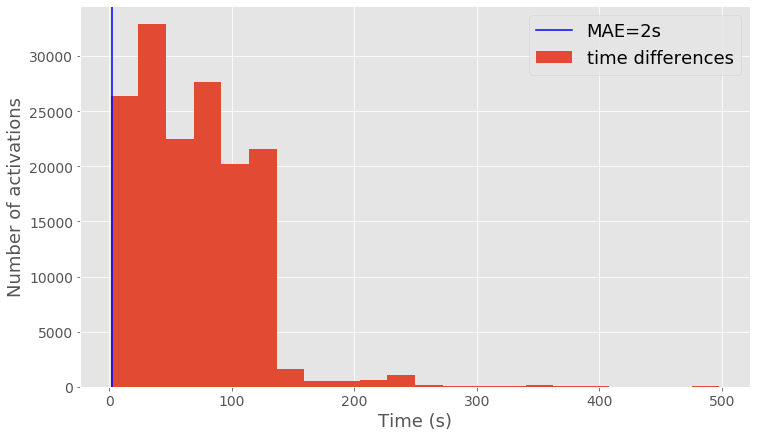

In [78]:
matplotlib.rcParams.update({'font.size': 14})
fig = plt.figure(facecolor='white', figsize=(12,7)) 
plt.hist(diff_list_s_clean, bins=22)
plt.axvline(x=2, color='blue')
plt.legend(['MAE=2s','time differences',], loc='best', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Number of activations', fontsize=18)
plt.show()